# Covariance matrix estimation and MVP optimisation


In this notebook, we have the following goals:

1. Explore the mathematics behind i.i.d. covariance sample matrix distribution in form of the Marchenko-Pastur distribution.
2. Based on this, implement classical linear (clipping) and non-linear (Ledoit-Wolf 2020 with kernel smoothening) denoising strategies.
3. Implement two simple neural net (few layers of perceptrons) based denoising strategies. Trained on either normal, or GARCH distributed data.
4. Benchmark the four denoising algorithms on different synthetic datasets.
5. Benchmark the denoising algorithms on Daily SP500 returns, comparing their efficiency of finding the minimum variance portfolio.
6. (Disjoint from the other aims:) Empirically confirm Riemann zeta function random matrix based behaviour and draw some mild conclusions on universality.




In [22]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import ssl
import certifi
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm, gaussian_kde
from mpmath import mp, zeta, zetazero


# 1. I.i.d covariance matrices and Marchenko-Pastur

Assume we have a matrix $X$ that is a sample of $m$ observations of $n$ features of a population that is i.i.d $\mathcal{N}(0,1)$ distributed, we can estimate the population covariance matrix with sample covariance matrix. By definition, the population covariance matrix is the identity, in particular all its eigenvalues are $1$. As it turns out, this is not what we can expect for the sample covariance matrix. Instead its Eigenvalues are, at least in the limit case, distributed according to the Marchenko-Pastur distribution.

### Marchenko-Pastur distribution

We first define the MP probability density function. Given $\lambda=m/n$, the ratio between rows and columns of the random matrice, and fixed $\sigma^2$, we set $\lambda_\pm=\sigma^2(1\pm \sqrt{\lambda})^2$ and define the MP p.d.f as
$$f(x)=\begin{cases}\frac{\sqrt{(\lambda_+-x)(x-\lambda_-)}}{2 \pi \lambda \sigma^2 x} & \text{if } \lambda_-\leq x \leq \lambda_+\\
1-1/\lambda & \text{if } x=0 \text{ and } \lambda>1\\
0 &\text{else}
\end{cases}$$

In [2]:
def mpPDF(x, lam, sig_sq=1.0):
    """
    Returns the Marchenko-Pastur Probability Density Function
    Args:
        x (float or np.ndarray): Point(s) at which to evaluate MP p.d.f
        lam (float): m/n ratio (observations / features).
        sig_sq (float): Variance of the underlying noise.
    """

    x = np.asarray(x, dtype=float)
    out=np.zeros_like(x)
    #Define \lambda_{\pm}
    eMin = sig_sq * (1 - np.sqrt(lam))**2
    eMax = sig_sq * (1 + np.sqrt(lam))**2


    mask= (x > max(eMin, 0)) & (x < eMax)
    inner = (eMax - x) * (x - eMin)
    numerator = np.sqrt(np.maximum(0, inner))
    denominator=2*np.pi*lam*x*sig_sq
    out[mask]=numerator[mask]/denominator[mask]

    #Adding point mass at 0, if m>n:
    if lam > 1:
        out[x == 0] = 1 - 1 / lam

    return out


Let's graph this for some choices of $\lambda$

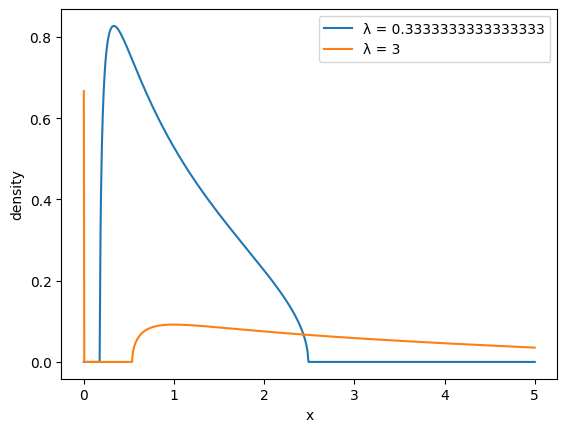

In [3]:
#Choice of lambdas
lams = [1/3,3]

#Plot range
x = np.linspace(0, 5, 1000)

#Creating plot
plt.figure()
for lam in lams:
    y =  mpPDF(x, lam)
    plt.plot(x, y, label=f"λ = {lam}")

plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.show()

Let $X$ be a $m\times n$ random Matrix with i.i.d standard normal entries. Let $Y=\frac{X X^T}{n}$ with eigenvalues $\lambda_1, \ldots, \lambda_m$. The  Marchenko-Pastur Theorem states that the associated random measure converges, as $m,n \to \infty$, to the MP density with $\lambda=m/n$.

Note that $X^TX$ and $X^T X$ have the same non-zero Eigenvalues, with same multiplicity. Denote the Eigenvalues of $Y'=\frac{X X^T}{m}$ by $\mu_1, \ldots, \mu_n$, we can map the non-zero ones via $\mu_{i}m=\lambda_{i}n$, thus $\lambda \mu_i=\lambda_i$. Since $\mu$ is MP distributed with $1/\lambda=n/m$, this shows that outside of the point mass $MP(x,\lambda)=\frac{MP(x/\lambda,1/\lambda)}{\lambda^2}$. Note that here MP is not the density measure, but the function defined above.

In particular, this means we can w.l.o.g. choose $\lambda\leq 1$ to have no point-mass at $0$.

We can also confirm this fact graphically

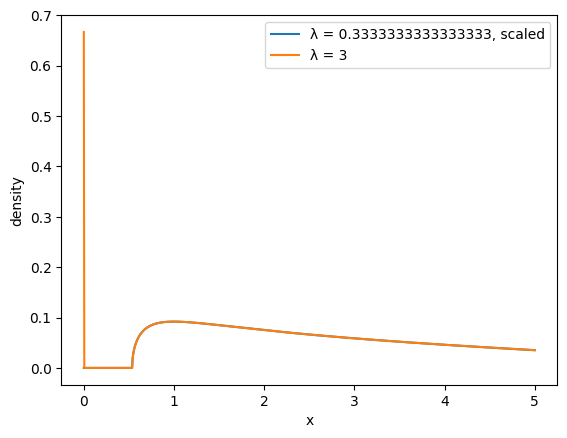

In [4]:
x = np.linspace(0, 5, 1000)

#Define a test set of lambdas, ideally containing pairs \lambda, 1/\lambda.
lams = [1/3,3]

plt.figure()

#Compare the rescaled values
for lam in lams:
    if lam >= 1:
        y =  mpPDF(x, lam)
        plt.plot(x, y, label=f"λ = {lam}")
    else:
        y = mpPDF(x * lam, lam)*lam**2
        plt.plot(x, y, label=f"λ = {lam}, scaled")


plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.show()

Let us briefly confirm that the MP distribution indeed models the distribution of sample eigenvalues.

In [55]:
rng = np.random.default_rng(42)

#Dimensions of Matrix:
m=1500
n=500

#Number of matrices. The MP theorem applies in the m,n->infty limit. Other distributions appear in the large N case.
N=1

#Initialising list of Eigenvalues:
e_vals = []

#Calculating correlation matrices and using np.linalg.eigval to obtain Eigenvalues.
for i in range(N):
    X=rng.normal(0,1,size=(m,n))
    Y= np.matmul(np.transpose(X),X)/m
    e_vals.append(np.sort(np.linalg.eigvals(Y))[::-1])
e_vals = np.real_if_close(np.round(np.array(e_vals), decimals=10))
print(X.shape)
print(e_vals)

(1500, 500)
[[2.498  2.4658 2.4091 2.3953 2.3662 2.3624 2.3313 2.3215 2.2879 2.2835
  2.2712 2.2542 2.2341 2.2266 2.2187 2.1983 2.1906 2.1772 2.1692 2.1573
  2.1481 2.1281 2.1202 2.1087 2.1048 2.0966 2.0883 2.0697 2.0604 2.0471
  2.0376 2.0322 2.0244 2.0183 2.0019 2.0006 1.9936 1.9793 1.9702 1.9637
  1.9492 1.9462 1.941  1.9347 1.9241 1.9124 1.9028 1.898  1.8965 1.8852
  1.8813 1.866  1.8586 1.8541 1.8402 1.8349 1.8307 1.8281 1.8103 1.8078
  1.7977 1.7918 1.7896 1.7807 1.7659 1.762  1.7544 1.7464 1.7427 1.7375
  1.7271 1.7258 1.7124 1.7085 1.701  1.6957 1.6865 1.6855 1.6801 1.6684
  1.6661 1.6591 1.6588 1.6525 1.6475 1.6414 1.6366 1.6248 1.6208 1.614
  1.6085 1.6065 1.5974 1.5877 1.5834 1.577  1.5743 1.5667 1.5606 1.5587
  1.5447 1.5401 1.5344 1.5306 1.5225 1.5221 1.512  1.5052 1.5033 1.4921
  1.4903 1.4832 1.4728 1.4695 1.4623 1.4605 1.4566 1.452  1.4492 1.4413
  1.4373 1.4357 1.4265 1.4192 1.4135 1.4069 1.4013 1.4002 1.3946 1.3921
  1.3864 1.3822 1.3774 1.3743 1.3706 1.3669 1.3596 1.

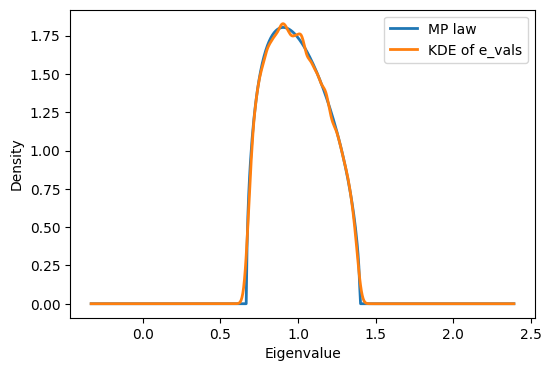

In [48]:
#Define a simple smoothening kernel
def kde(x, data, h=0.1):
    # Ensure data is a 1D numpy array
    data = np.asarray(data).ravel()

    diffs = x[:, None] - data[None, :]
    # Average of normals
    res = np.mean(norm.pdf(diffs, loc=0, scale=h), axis=1)
    return res


def plot_MP_alt(e_vals, lam, sig_sq=1.0, h=0.01):
    """
    Creates a graph that compares the distribution of a list of Eigenvalues against a theoretical MP distribution.
    Args:
        e_vals (p.ndarray): Eigenvalues, possibly multidimensional list.
        lam (float): m/n ratio (observations / features) for plotting MP pdf.
        sig_sq (float): Variance of the underlying noise for plotting MP pdf.
    """

    graph_min=np.quantile(e_vals, 0)-1
    graph_max=np.quantile(e_vals, 1)+1



    x = np.linspace(graph_min, graph_max, 500)
    y = mpPDF(x, lam=lam, sig_sq=sig_sq)
    z = kde(x, e_vals, h=h)

    plt.figure(figsize=(6,4))
    plt.plot(x, y, lw=2, label="MP law")
    plt.plot(x, z, lw=2, label="KDE of e_vals")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_MP_alt(e_vals, n/m, h=0.02)


# 2. Classic estimation improvement

We define two methods of improving population estimation:

The first one is based directly on the MP distribution and moves all eigenvalues below the MP upper limit $\lambda_+$ closer to their average, depending on a factor lin. Here $lin=1$ means no change and $lin=0$ replaces all small eigenvalues by the average.

In [56]:

def e_val_lin(e_vals, lam, lin=0, sig_sq=1):
    """
    Moves all eigenvaleus below MP predicted \lambda_+ closer to their average. This preserves the trace.
    Args:
        e_vals (p.ndarray): Eigenvalues, possibly multidimensional list.
        lam (float): m/n ratio (observations / features) for calculating MP maximum.
        lin (float): Scaling value, most sensibly between 0 and 1.
        sig_sq (float): Estimated Variance for calculating MP maximum pdf.
    """
    #Prevent modification of input array:
    e_vals=e_vals.copy()

    #Define \lambda_+ and add numerical wiggle room to account for finite samples
    eMax = sig_sq * (1 + np.sqrt(lam))**2+0.01

    # Identify indices of noise eigenvalues
    is_noise = e_vals <= eMax
    n_noise = np.sum(is_noise)

    if n_noise > 0:
        # Extract the noise subset
        noise_subset = e_vals[is_noise]
        avg_noise = np.mean(noise_subset)

        # Apply linear shrinkage
        e_vals_denoised = e_vals
        e_vals_denoised[is_noise] = avg_noise + lin * (noise_subset - avg_noise)

        return e_vals_denoised
    return e_vals

print(e_val_lin(e_vals, n/m))

[[1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001 1.001
  1.001 1.001 1.001 1.001 1.001 1.001 

The second method, based on Ledoit-Wolf: 'Nonlinear shrinkage estimation of large-dimensional covariance matrices' (or more precisely the implementation in their 2020 work 'Analytical Nonlinear Shrinkage of large-dimensional Covariance Matrices') is only indirectly using MP distribution. It replaces all eigenvalues by shrinked values, which are optimal assuming the noise is MP distributed.






In [61]:
#The following implementation of the non-linear shrinking is based closely on the paper description.
#Note: Because of the relative complexity, this part was LLM assisted.


def ledoit_wolf_2020_stable(e_vals, n, m, *, eps=1e-12):
    """
    Ledoit & Wolf (2020) analytical non-linear eigenvalue shrinkage (nonsingular case p<n_obs).

    Parameters
    ----------
    e_vals : array_like, shape (n,) or (N, n)
        Sample covariance eigenvalues (positive, typically sorted but not required).
        Here p = n is the matrix dimension.
    n : int
        Dimension p (number of variables).
    m : int
        Sample size (number of observations). In your code, X is (m, n) and Y = X^T X / m.
    eps : float
        Numerical stability constant.

    Returns
    -------
    d : ndarray, shape (n,) or (N, n)
        Shrunk eigenvalues (same shape as input).
    """
    lam_in = np.asarray(e_vals, dtype=np.float64)
    if lam_in.ndim == 1:
        lam_in = lam_in[None, :]  # (1, p)
    if lam_in.shape[1] != n:
        raise ValueError(f"Expected e_vals.shape[1] == n == {n}, got {lam_in.shape}")

    p = n
    c = p / float(m)  # concentration ratio p/n_sample
    # Global bandwidth h_n = n_sample^{-1/3} in the paper's notation (their "n" is sample size). :contentReference[oaicite:0]{index=0}
    h = m ** (-1.0 / 3.0)
    sqrt5 = np.sqrt(5.0)
    pi = np.pi

    out = np.empty_like(lam_in)

    for k in range(lam_in.shape[0]):
        lam = np.maximum(lam_in[k], eps)  # ensure strictly positive
        hj = np.maximum(lam * h, eps)     # local bandwidths h_{n,j} = lambda_j * h_n :contentReference[oaicite:1]{index=1}

        # Broadcasted differences: diff[i,j] = lambda_i - lambda_j
        diff = lam[:, None] - lam[None, :]
        hj_row = hj[None, :]  # depends on j
        z = diff / hj_row

        # --- Spectral density estimator f_hat at lambda_i (Epanechnikov, positive part) :contentReference[oaicite:2]{index=2}
        poly = 1.0 - (z * z) / 5.0
        k_pos = np.maximum(poly, 0.0)
        f_hat = (3.0 / (4.0 * sqrt5)) * (k_pos / hj_row)
        f_hat = f_hat.mean(axis=1)

        # --- Hilbert transform estimator Hf_hat at lambda_i :contentReference[oaicite:3]{index=3}
        hj2_row = hj_row * hj_row
        term1 = -3.0 * diff / (10.0 * pi * hj2_row)

        a = sqrt5 * hj_row
        denom = a + diff
        numer = a - diff

        # log(|(a - diff)/(a + diff)|), clipped to avoid log(0)
        ratio_abs = np.abs(numer / np.where(np.abs(denom) < eps, np.sign(denom) * eps, denom))
        ratio_abs = np.maximum(ratio_abs, eps)
        log_term = np.log(ratio_abs)

        # At the boundary diff^2 == 5*h_j^2, the paper defines the last term as zero. :contentReference[oaicite:4]{index=4}
        edge = np.isclose(diff * diff, 5.0 * hj2_row, rtol=0.0, atol=1e-14)
        poly_edge = np.where(edge, 0.0, poly)

        term2 = (3.0 / (4.0 * sqrt5 * pi)) * (poly_edge / hj_row) * log_term
        H_hat = (term1 + term2).mean(axis=1)

        # --- Oracle shrinkage mapping d(x) (plug-in): equation (3.3) :contentReference[oaicite:5]{index=5}
        denom_shrink = (pi * c * lam * f_hat) ** 2 + (1.0 - c - pi * c * lam * H_hat) ** 2
        denom_shrink = np.maximum(denom_shrink, eps)
        d = lam / denom_shrink

        out[k] = d

    return out[0] if np.asarray(e_vals).ndim == 1 else out

new_evs=ledoit_wolf_2020_stable(e_vals, n, m)

print(f"Original Min: {e_vals.min():.4f} -> Denoised Min: {new_evs.min():.4f}")
print(f"Original Max: {e_vals.max():.4f} -> Denoised Max: {new_evs.max():.4f}")

Original Min: 0.1805 -> Denoised Min: 0.8502
Original Max: 2.4980 -> Denoised Max: 1.2370


# 3. NN estimation

We next want to train a multilayer perceptron. Remark: During the work on this project an article applying a similar idea has been put on Arxiv: https://arxiv.org/pdf/2601.15597 . However, our path here is considerably simpler and avoids transformers.

We first create synthetic training data. As the goal is to use this on SP500 MVP construction, we use the following axioms for eigenvalue distribution:
1. There is a leading market mode.
2. We have 5-10 factor signals.
3. The remaining noise bulk accounts for $40-50$% of variance.



# 4. Synthetic Benchmarks

In [38]:
def mat_denoise_clipping(returns):
    """"Returns a clipping denoised correlation matrix"""
    m, n = returns.shape
    Y = (returns.T @ returns) /m
    lam=n/m

    if m <= n:
        raise ValueError("Invalid parameter regime: expected m > n")

    e_vals, e_vecs = np.linalg.eigh(Y)

    # Ensure EVs are real and clip tiny negative values caused by float precision
    e_vals = np.maximum(e_vals.real, 0)

    sig_sq_est = estimate_sig_sq(e_vals)

    denoised_e_vals=e_val_denoise_clipping(e_vals, lam, sig_sq=sig_sq_est)

    denoised_Y= e_vecs @ np.diag(denoised_e_vals) @ e_vecs.T

    #Enforcing symmetry
    denoised_Y = (denoised_Y + denoised_Y.T) / 2
    return denoised_Y


def mat_denoise_nonlinear(returns):
    """"Returns a non-linear denoised correlation matrix"""
    m, n = returns.shape
    Y = (returns.T @ returns) /m
    lam=n/m

    if m <= n:
        raise ValueError("Invalid parameter regime: expected m > n")

    e_vals, e_vecs = np.linalg.eigh(Y)
    # Ensure EVs are real and clip tiny negative values caused by float precision
    e_vals = np.maximum(e_vals.real, 0)


    denoised_e_vals=e_val_denoise_nonlinear(e_vals, lam)

    denoised_Y= e_vecs @ np.diag(denoised_e_vals) @ e_vecs.T

    #Enforcing symmetry
    denoised_Y = (denoised_Y + denoised_Y.T) / 2
    return denoised_Y


print(mat_denoise_clipping(returns))

[[1.0821 0.4502 0.336  ... 0.4088 0.5236 0.546 ]
 [0.4502 0.9795 0.2034 ... 0.3234 0.4895 0.4445]
 [0.336  0.2034 0.8743 ... 0.3092 0.1718 0.3363]
 ...
 [0.4088 0.3234 0.3092 ... 0.9567 0.3431 0.394 ]
 [0.5236 0.4895 0.1718 ... 0.3431 0.9491 0.4276]
 [0.546  0.4445 0.3363 ... 0.394  0.4276 0.9363]]




# 5. MVP Benchmarking

### Importing SP500 daily returns

We do the denoising process on Daily SP500 returns, imported with the yfinance module.

In [2]:
#Fixing MacOs SSL certificate for webscraping, using online found code:
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
os.environ['SSL_CERT_FILE'] = certifi.where()

# This is a 'brute force' for the SSL module itself
ssl._create_default_https_context = ssl._create_unverified_context

print(f"Certificates pointed to: {certifi.where()}")

Certificates pointed to: /Users/lassegrimmelt/PycharmProjects/PythonProject/.venv1/lib/python3.11/site-packages/certifi/cacert.pem


In [3]:
url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"

try:
    # Read the CSV directly from the web
    sp500_df = pd.read_csv(url)
    tickers = sp500_df['Symbol'].tolist()

    # Standardize tickers for yfinance (e.g., BRK.B -> BRK-B)
    tickers = [t.replace('.', '-') for t in tickers]
    print(f"Successfully loaded {len(tickers)} tickers.")
except Exception as e:
    print(f"Fallback required: {e}")

Successfully loaded 503 tickers.


In [4]:
# Download Daily Close (with forced auto_adjust)
raw_data = yf.download(tickers, auto_adjust=True, start="2020-01-01", end="2026-01-01")

[**********************49%                       ]  244 of 503 completed$FI: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-01) (Yahoo error = "No data found, symbol may be delisted")
[**********************52%                       ]  264 of 503 completedHTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
[**********************54%*                      ]  270 of 503 completed$WBA: possibly delisted; no timezone found
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['FI']: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-01) (Yahoo error = "No data found, symbol may be delisted")
['WBA']: possibly delisted; no timezone found


In [5]:
#Create close data
SPdata = raw_data['Close']
SPdata.shape

(1508, 503)

There are some NaN values, for this toy model we do a naive cleaning:
1. Remove any ticker with more than $10\%$ missing values.
2. Forward fill all other missing values.

While the second point prevents backwards time leakeage, one may consider more sophisticated methods.


In [6]:
#Drop columns with too many NaNs, forward fill other NaNs.
SPdata = SPdata.dropna(axis=1, thresh=len(SPdata)*0.9).ffill()
SPdata = SPdata.dropna(axis=0)
#SPdata.shape
np.any(np.isnan(SPdata)) #Sanity check if NaN is remaining


np.False_

In [42]:
print(SPdata.shape)

(1455, 490)


In [49]:
#Calculate returns and normalise them to have mean 0 and std 1
def norm_returns(raw):
    returns= np.log(raw).diff().dropna()
    returns -= returns.mean()
    returns /= returns.std(ddof=1)
    return returns


returns = create_returns(SPdata)
print(returns)


Ticker             A      AAPL      ABBV       ABT      ACGL       ACN  \
Date                                                                     
2020-03-20  0.558440 -3.544486 -2.210800 -6.038204 -2.214352 -3.169911   
2020-03-23 -2.671929 -1.197889 -4.408434 -5.244437 -5.855377 -2.436523   
2020-03-24  3.062489  5.029451  2.971516  6.804325  5.003800  4.942107   
2020-03-25  1.603339 -0.349576  0.351014  0.965661  0.198754 -1.870832   
2020-03-26  3.643385  2.672055  5.535586  4.519495  7.481159  6.830425   
...              ...       ...       ...       ...       ...       ...   
2025-12-24 -0.045352  0.226659  0.256704  0.114427 -0.352932 -0.189350   
2025-12-26 -0.001221 -0.135468 -0.038445 -0.012321 -0.338218  0.208724   
2025-12-29 -0.214108  0.014231  0.185418 -0.170678  0.237371  0.028456   
2025-12-30 -0.154193 -0.188050 -0.384715  0.608242  0.099720 -0.304323   
2025-12-31 -0.658001 -0.293922 -0.430226 -0.285110 -0.452686 -0.381707   

Ticker          ADBE       ADI       

Mathematically, the MP distribution assumes that the underlying random variables are normal distributed. We expect that our log returns are more heavy tailed.

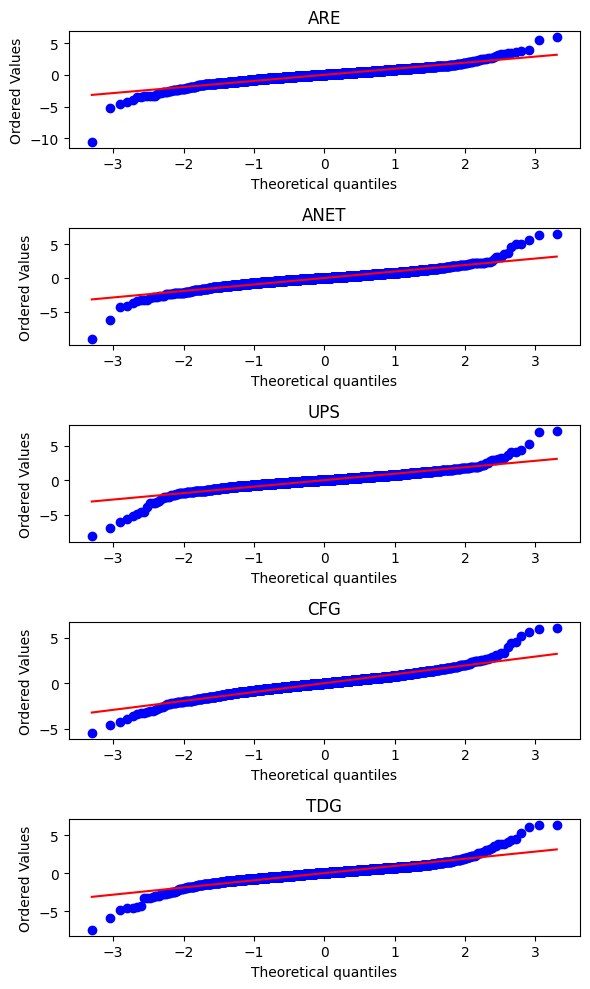

In [14]:
#Pick a random selection of assets and QQ
assets = np.random.choice(returns.columns, size=5, replace=False)

fig, axes = plt.subplots(len(assets), 1, figsize=(6, 10))

for ax, asset in zip(axes, assets):
    stats.probplot(returns[asset].dropna(), dist="norm", plot=ax)
    ax.set_title(asset)

plt.tight_layout()
plt.show()

In [15]:
##OBSOLETE CELL?

sp_e_vals=[]

Y= np.matmul(np.transpose(returns),returns)/returns.shape[1]

sp_e_vals=np.sort(np.linalg.eigvals(Y))[::]
sp_e_vals = np.real_if_close(np.round(np.array(sp_e_vals), decimals=10), tol=10)
print(returns.shape)
print(Y.shape)
print(sp_e_vals)


(1454, 490)
(490, 490)
[9.04693950e-03 1.91845199e-02 3.96534236e-02 7.90522655e-02
 8.52068318e-02 9.64733275e-02 9.85813356e-02 1.00023424e-01
 1.02627693e-01 1.04816003e-01 1.06390743e-01 1.09505662e-01
 1.13116042e-01 1.17129056e-01 1.20275737e-01 1.21421029e-01
 1.23541366e-01 1.24792726e-01 1.25934824e-01 1.29063506e-01
 1.32318378e-01 1.33164066e-01 1.34340468e-01 1.39882722e-01
 1.41068758e-01 1.42840807e-01 1.45220601e-01 1.46893372e-01
 1.49146978e-01 1.52917553e-01 1.55400116e-01 1.57295693e-01
 1.58779305e-01 1.61655981e-01 1.66116920e-01 1.68985450e-01
 1.70227600e-01 1.71017735e-01 1.72319190e-01 1.75728775e-01
 1.77341186e-01 1.80577197e-01 1.81891402e-01 1.84296215e-01
 1.86423631e-01 1.90833024e-01 1.92753208e-01 1.94767810e-01
 1.94993339e-01 1.98417190e-01 1.99758978e-01 2.02978054e-01
 2.04606196e-01 2.04668877e-01 2.09137547e-01 2.11765468e-01
 2.14133385e-01 2.16215352e-01 2.18758163e-01 2.20188273e-01
 2.22782776e-01 2.25269276e-01 2.28095377e-01 2.30775167e-01
 

In [26]:
#Compute the Covariance matrix
# Assuming returns shape is (m_observations, n_features)
# Y = (1/m) * X^T * X
m, n = returns.shape
Y = (returns.T @ returns) /m

# Extract Eigenvalues and Eigenvectors
# returns e_vals in ASCENDING order
sp_e_vals, sp_e_vecs = np.linalg.eigh(Y)

# Ensure EVs are real and clip tiny negative values caused by float precision
sp_e_vals = np.maximum(sp_e_vals.real, 0)

print(f"m is {m}, n is {n}")
print(f"Returns shape: {returns.shape} (m_obs, n_feat)")
print(f"Matrix Y shape: {Y.shape}")
print(f"Largest 3 EVs: {sp_e_vals[-3:][::-1]}")



m is 1454, n is 490
Returns shape: (1454, 490) (m_obs, n_feat)
Matrix Y shape: (490, 490)
Largest 3 EVs: [168.54995079  28.00418912  24.45525134]
(490, 490)


Having calcualted the covariance matrix, we compare it against the MP distribution:

In [ ]:
plot_MP_alt(sp_e_vals,491/1455, h=0.05)

This does not match, because we can't assumie $\sigma=1$. Estimate $\sigma$ and plot again.

Estimated Sigma^2: 0.3985


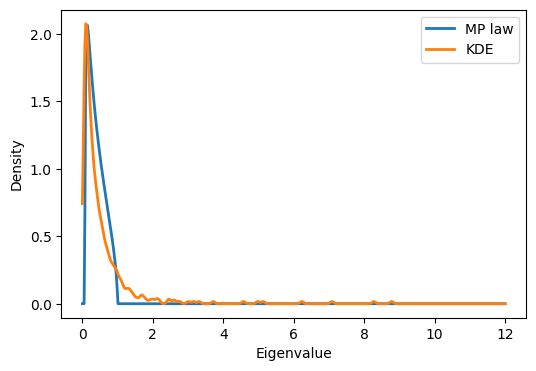

In [29]:
def estimate_sig_sq(e_vals):
    """
    Estimates the variance of the noise bulk. We assume that the lowest 95% of the Eigenvalues are nosie and use the fact that the mean of MP distribution EVs is sig_sq to estimate it form sample.
    """

    n = len(e_vals)
    bulk_limit = int(n * 0.95)
    sigma2 = np.mean(e_vals[:bulk_limit])

    return sigma2


sig_sq_est = estimate_sig_sq(sp_e_vals)
print(f"Estimated Sigma^2: {sig_sq_est:.4f}")

plot_MP_alt(sp_e_vals, lam=491/1455, sig_sq=sig_sq_est, h=0.05)

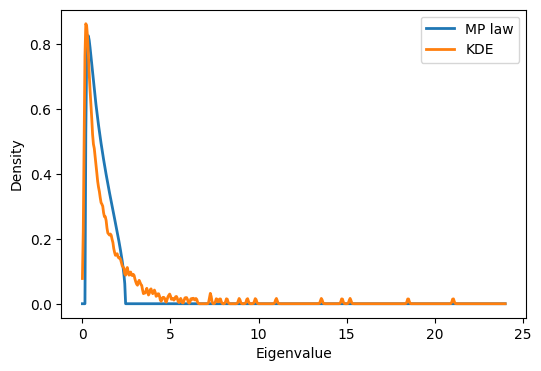

In [102]:
plot_MP_alt(sp_e_vals,491/1455, h=0.05, sig_sq=0.98)

In [75]:

def min_variance_portfolio(Sigma):
    if Sigma.shape[0]!=Sigma.shape[1]:
        raise ValueError("Needs a square matrix")

    ones = np.ones(Sigma.shape[0])

    x = np.linalg.solve(Sigma, ones)
    return x / (ones @ x)



def comparison(SPdata=SPdata, input_days=1000, test_window=60, rebalancing_times=1):



    if input_days + test_window*rebalancing_times > SPdata.shape[0]:
        raise ValueError("Too few days in data")


    for j in range(rebalancing_times):
        print(f'starting day for train {j*test_window}, end day for train {input_days+j*test_window}')
        train_mat = SPdata.iloc[j*test_window : input_days + j*test_window,:]

        test_mat = SPdata.iloc[input_days + j*test_window : input_days + (j+1)*test_window,:]

        train_returns=norm_returns(train_mat)

        test_returns = np.log(test_mat).diff().dropna()

        port1=np.ones(SPdata.shape[1])/ SPdata.shape[1]



        Sigma= np.matmul(np.transpose(train_returns),train_returns)/train_returns.shape[0]

        port2=min_variance_portfolio(Sigma)

        Sigma_denoised_1= mat_denoise_clipping(train_returns)

        port3=min_variance_portfolio(Sigma_denoised_1)

        Sigma_denoised_2= mat_denoise_nonlinear(train_returns)

        port4=min_variance_portfolio(Sigma_denoised_2)


        port1_rets = test_returns @ port1
        port2_rets = test_returns @ port2
        port3_rets = test_returns @ port3
        port4_rets = test_returns @ port4

        realised_vol1 = port1_rets.std(ddof=1)
        realised_vol2 = port2_rets.std(ddof=1)
        realised_vol3 = port3_rets.std(ddof=1)
        realised_vol4 = port4_rets.std(ddof=1)

        results = pd.DataFrame(
        {
            "Realised Vol": [
                realised_vol1,
                realised_vol2,
                realised_vol3,
                realised_vol4,
            ],
            "Mean Log Return": [
                port1_rets.mean(),
                port2_rets.mean(),
                port3_rets.mean(),
                port4_rets.mean(),
            ],
        },
        index=[
            "Equal Weight",
            "MVP (Raw)",
            "MVP (Clipped)",
            "MVP (Nonlinear)",
        ],
        )

        print(results.round(6))


comparison(SPdata, 700, 150, 5)



starting day for train 0, end day for train 700
                 Realised Vol  Mean Log Return
Equal Weight         0.009159         0.000762
MVP (Raw)            0.014296         0.002220
MVP (Clipped)        0.008860         0.000605
MVP (Nonlinear)      0.009701         0.001231
starting day for train 150, end day for train 850
                 Realised Vol  Mean Log Return
Equal Weight         0.007950         0.000698
MVP (Raw)            0.014498         0.001433
MVP (Clipped)        0.010698         0.001020
MVP (Nonlinear)      0.011424         0.001101
starting day for train 300, end day for train 1000
                 Realised Vol  Mean Log Return
Equal Weight         0.007426         0.000590
MVP (Raw)            0.011836        -0.000820
MVP (Clipped)        0.009164         0.000010
MVP (Nonlinear)      0.010172        -0.000405
starting day for train 450, end day for train 1150
                 Realised Vol  Mean Log Return
Equal Weight         0.012925        -0.000147
M

We conclude the following  (well-known) results:
1. Denoising consistently reduces the realised volatility in test space
2. Clipped denoising performs better most of the time
3. For similar reasons, equal weighting performs usually better
4. While not being optimised for it in any way, raw MVP outperforms equal weights in returns (but has higher vol).


# 6. RMT Universality

The Riemann-zeta function $\zeta(s)$ is a central object of analytic number theory. Of particular interest are its zeros $\zeta(\rho_n)=0$. We believe these zeroes to follow certain distribution laws coming from RMT.

We now consider the following formula, based on eq. (8) in 'A HYBRID EULER-HADAMARD PRODUCT FORMULA FOR THE
RIEMANN ZETA FUNCTION' by Gonek, Hughes, Keating:
$$\zeta(1/2+it)\approx \prod_{p\leq X}(1-p^{-1/2-i t})^{-1} \prod_{|\rho_n-t|\leq 1/\log X} (i (t-\rho_n) e^\gamma \log X)  $$

We propose the following analogy to MP denoising:
1. The product over $\rho_n$ behaves asymptotically just as predicted by a GUE RMT. In particular, this is based on independent inputs.
2. Since the distribution of primes is not completely independent, there is additional effect from small prime factors, captured by the first product.
3. Just as we treat eigenvalues of the correlation matrix outside of MP distribution as signal, we should be able extract the prime signal points out of \zeta by dividing out the contribution of zeroes.

To test this, we try to discover the location of small primes by dividing out of $\zeta$ the contribution of zeroes:
$$ \sum_{p\leq X} \log ( 1-e^{\log p (-1/2-it)})\approx -\log \zeta(1/2+it)+\sum_{|\rho_n-t|\leq 1/\log X} \log(i (t-\rho_n) e^\gamma \log X)$$

In [73]:
from tqdm.notebook import tqdm
# We may require larger precision for large T:
mp.dps = 15


def get_approx_index(t_target):
    """Estimate the index n for the first zero above t_target."""
    return int((t_target / (2 * np.pi)) * (np.log(t_target / (2 * np.pi)) - 1))

def get_zeroes_in_interval(t_min, t_max):
    """"Obtain zeroes in intervals and checks plausibility"""
    n_max = get_approx_index(t_max)+20
    n_min = get_approx_index(t_min)-20

    zeroes_window = [0]
    for i in range(max(n_min,1), n_max):
        zeroes_window.append(mp.zetazero(i).imag)
        print(f'Found {i} out of {n_max-max(n_min,1)} zeroes')

    zeros_interval= [float(r) for r in zeroes_window if t_min<r < t_max]
    print(f'After clipping {len(zeros_interval)} zeroes remain')
    return np.array(zeros_interval)


print(get_zeroes_in_interval(100, 115))


Found 8 out of 46 zeroes
Found 9 out of 46 zeroes
Found 10 out of 46 zeroes
Found 11 out of 46 zeroes
Found 12 out of 46 zeroes
Found 13 out of 46 zeroes
Found 14 out of 46 zeroes
Found 15 out of 46 zeroes
Found 16 out of 46 zeroes
Found 17 out of 46 zeroes
Found 18 out of 46 zeroes
Found 19 out of 46 zeroes
Found 20 out of 46 zeroes
Found 21 out of 46 zeroes
Found 22 out of 46 zeroes
Found 23 out of 46 zeroes
Found 24 out of 46 zeroes
Found 25 out of 46 zeroes
Found 26 out of 46 zeroes
Found 27 out of 46 zeroes
Found 28 out of 46 zeroes
Found 29 out of 46 zeroes
Found 30 out of 46 zeroes
Found 31 out of 46 zeroes
Found 32 out of 46 zeroes
Found 33 out of 46 zeroes
Found 34 out of 46 zeroes
Found 35 out of 46 zeroes
Found 36 out of 46 zeroes
Found 37 out of 46 zeroes
Found 38 out of 46 zeroes
Found 39 out of 46 zeroes
Found 40 out of 46 zeroes
Found 41 out of 46 zeroes
Found 42 out of 46 zeroes
Found 43 out of 46 zeroes
Found 44 out of 46 zeroes
Found 45 out of 46 zeroes
Found 46 out o

In [96]:
zeroes=get_zeroes_in_interval(0.1, 10000)

Found 1 out of 10161 zeroes
Found 2 out of 10161 zeroes
Found 3 out of 10161 zeroes
Found 4 out of 10161 zeroes
Found 5 out of 10161 zeroes
Found 6 out of 10161 zeroes
Found 7 out of 10161 zeroes
Found 8 out of 10161 zeroes
Found 9 out of 10161 zeroes
Found 10 out of 10161 zeroes
Found 11 out of 10161 zeroes
Found 12 out of 10161 zeroes
Found 13 out of 10161 zeroes
Found 14 out of 10161 zeroes
Found 15 out of 10161 zeroes
Found 16 out of 10161 zeroes
Found 17 out of 10161 zeroes
Found 18 out of 10161 zeroes
Found 19 out of 10161 zeroes
Found 20 out of 10161 zeroes
Found 21 out of 10161 zeroes
Found 22 out of 10161 zeroes
Found 23 out of 10161 zeroes
Found 24 out of 10161 zeroes
Found 25 out of 10161 zeroes
Found 26 out of 10161 zeroes
Found 27 out of 10161 zeroes
Found 28 out of 10161 zeroes
Found 29 out of 10161 zeroes
Found 30 out of 10161 zeroes
Found 31 out of 10161 zeroes
Found 32 out of 10161 zeroes
Found 33 out of 10161 zeroes
Found 34 out of 10161 zeroes
Found 35 out of 10161 z

KeyboardInterrupt: 

In [115]:

def hybrid_difference(T, Tleng, X, zeroes=zeroes,  num_points=2000):
    t_vals=np.linspace(T-Tleng,T+Tleng,num_points)
    log_X = np.log(X)

    #Get zeta values
    zeta_vals = np.array([complex(mp.zeta(0.5 + 1j*t)) for t in t_vals])

    residues=[]
    for t in t_vals: #Not vectorised, could be improed:
        local_zeros = [r for r in zeroes if t-1/log_X<r <  t+1/log_X]
        Z = np.prod(1j*(t - local_zeros) * np.exp(0.5772) * log_X)

        residues.append( complex(mp.zeta(0.5 + 1j*t)/Z) )

    return t_vals, np.array(residues)


t1, X1= hybrid_difference(401,200,2000)


KeyboardInterrupt: 

In [111]:

t2, X2= hybrid_difference(401,200,1.1)


By the above theorem, we have for the residual function we just calculated that
$$R(t)\approx \prod_{p\leq X}(1-p^{-1/2-it})^{-1}=\sum_{n}\frac{a_n}{\sqrt{n}} e^{-i t \log n},$$

where $a_n=1$ iff $n$ consist only of prime factors less than $X$.

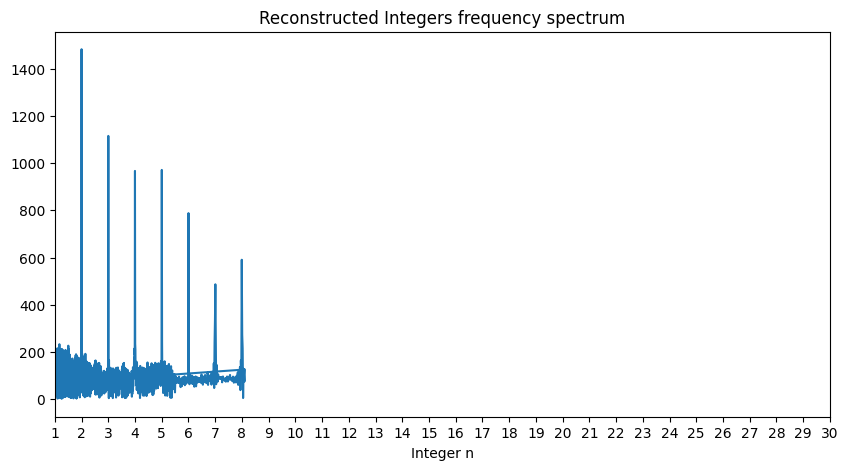

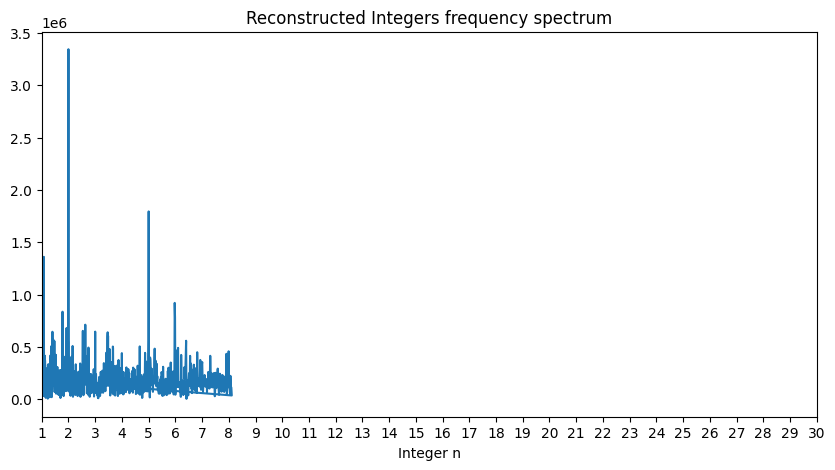

In [113]:
def plot_spectrum_on_n_axis(t, X):
    dt = t[1] - t[0]
    n_samples = len(t)

    # Compute FFT
    Y = np.fft.fft(X)
    # Conver frequencies
    freqs = np.fft.fftfreq(n_samples, d=dt) * 2 * np.pi

    # Since n = exp(omega), we transform the axis:
    omega = -freqs
    integers = np.exp(omega)

    mag = np.abs(Y)

    plt.figure(figsize=(10, 5))
    plt.plot(integers, mag)
    plt.xlim(1, 30) # Zoom in to see n = 2, 3, 4, 5...
    plt.xticks(range(1, 31))
    plt.xlabel('Integer n')
    plt.title('Reconstructed Integers frequency spectrum')
    plt.show()


plot_spectrum_on_n_axis(t1, X1-X1.mean())
plot_spectrum_on_n_axis(t2, X2-X2.mean())

We can more clearly see the effect by takin logarithms, since
$$\log R(t)\approx \sum_{p\leq X}\log(1-p^{-1/2-it})^{-1}\approx \sum_{p\leq X}\frac{\log p}{\sqrt{p}} e^{-i t \log p}$$.

In reality, there are also the higher prime powers, but this is a reasonable first approximation.

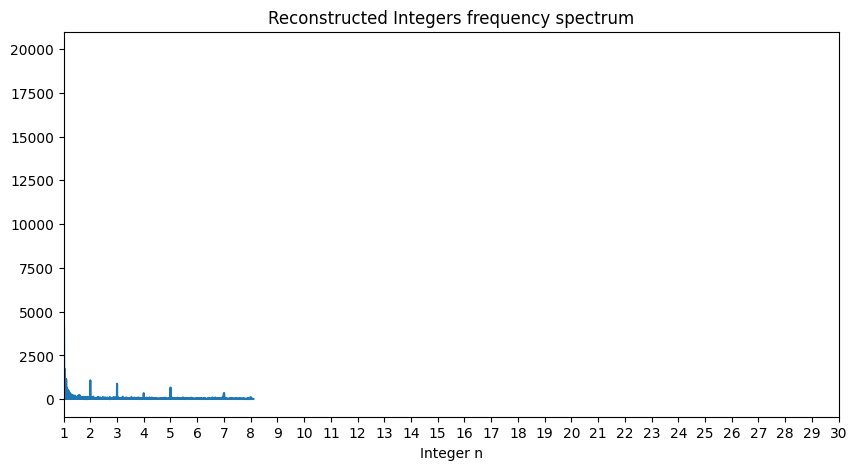

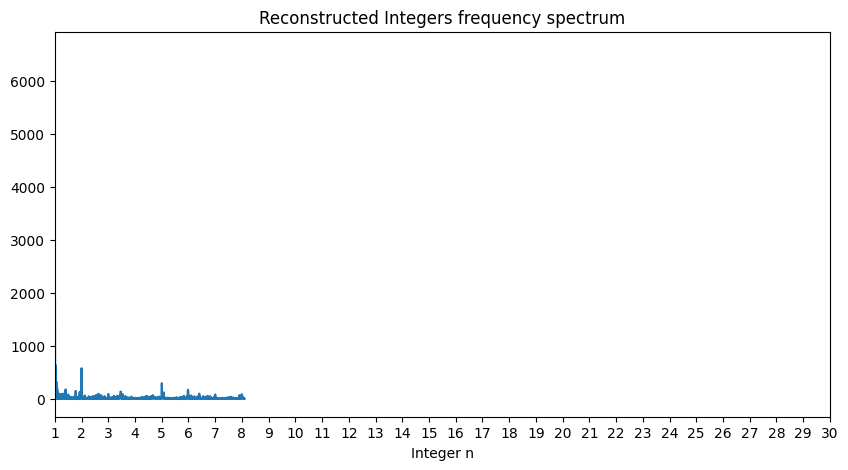

In [114]:

def get_log(vals):
    """Converts an array of function values into log values, respecting log branches. Requires sufficient resolution."""

    log_magnitudes=np.log(abs(vals))
    phases=np.angle(vals)
    continuous_phases = np.unwrap(phases)
    return np.array(log_magnitudes) + 1j * np.array(continuous_phases)


Y1=get_log(X1)
Y2=get_log(X2)

plot_spectrum_on_n_axis(t1, Y1-Y1.mean())
plot_spectrum_on_n_axis(t2, Y2-Y2.mean())

While we are running at the limit of the GHK formula, in particular the fact that approximation (8) is only valid in the $X$ to $\infty$ limit, we nevertheless can observe that taking more zeroes into account reduces the range of primes the residual function sees. This is clearly visible at $n=13, 19$, which have essentially disappeared in the second graph.


##Zeroes and GUE

As final step, we connect now the study of $\zeta$ to RMT predictions.


In [95]:
def rmt_analysis(zeros):
    # 1. Unfolding (Transformation to uniform mean density)
    # Using the Riemann-von Mangoldt formula for the average count N(T)
    unfolded = (zeros / (2 * np.pi)) * (np.log(zeros / (2 * np.pi)) - 1)

    # 2. Calculate Spacings
    spacings = np.diff(unfolded)

    # 3. GUE Distribution (Gauss-Wigner surmise for GUE)
    # This is the 'target' for our KS test
    def gue_pdf(s):
        return (32 / (np.pi**2)) * (s**2) * np.exp(-4 * s**2 / np.pi)

    # 4. Kolmogorov-Smirnov Test
    # We compare the empirical CDF of spacings to the GUE CDF
    def gue_cdf(s):
        # Integral of the GUE PDF
        from scipy.special import erf
        return erf(2*s/np.sqrt(np.pi)) - (4*s/np.pi) * np.exp(-4*s**2/np.pi)

    ks_stat, p_value = stats.kstest(spacings, gue_cdf)

    return spacings, ks_stat, p_value

# Usage:
# zeros = get_zeroes_in_interval(0.1, 1000)
s, ks, p = rmt_analysis(zeroes)


print(ks)
print(p)


0.0450125672374912
0.1403852520146851


In [101]:
import multiprocessing as mp_lib

def fetch_single_zero(i):
    """Worker function to fetch one zero ordinate."""
    # Convert to float immediately for efficient transfer back to main process
    return float(mp.zetazero(i).imag)

In [118]:
import concurrent.futures
import multiprocessing
import numpy as np
from zeta_worker import fetch_single_zero # Import from the file we just made

def get_zeroes_in_interval_parallel(t_min, t_max):
    n_min = max(get_approx_index(t_min) - 20, 1)
    n_max = get_approx_index(t_max) + 20
    indices = list(range(n_min, n_max))
    total = len(indices)

    num_cores = multiprocessing.cpu_count()
    print(f"Parallelizing on {num_cores} cores using zeta_worker.py...")

    results = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
        future_to_n = {executor.submit(fetch_single_zero, n): n for n in indices}

        count = 0
        for future in concurrent.futures.as_completed(future_to_n):
            results.append(future.result())
            count += 1
            if count % 10 == 0 or count == total:
                print(f"Found {count} / {total} zeroes...")

    results.sort()
    zeros_interval = [r for r in results if t_min < r < t_max]
    return np.array(zeros_interval)

# Run it
zeroes = get_zeroes_in_interval_parallel(0.1, 3000)

Parallelizing on 8 cores using zeta_worker.py...
Found 10 / 2486 zeroes...
Found 20 / 2486 zeroes...
Found 30 / 2486 zeroes...
Found 40 / 2486 zeroes...
Found 50 / 2486 zeroes...
Found 60 / 2486 zeroes...
Found 70 / 2486 zeroes...
Found 80 / 2486 zeroes...
Found 90 / 2486 zeroes...
Found 100 / 2486 zeroes...
Found 110 / 2486 zeroes...
Found 120 / 2486 zeroes...
Found 130 / 2486 zeroes...
Found 140 / 2486 zeroes...
Found 150 / 2486 zeroes...
Found 160 / 2486 zeroes...
Found 170 / 2486 zeroes...
Found 180 / 2486 zeroes...
Found 190 / 2486 zeroes...
Found 200 / 2486 zeroes...
Found 210 / 2486 zeroes...
Found 220 / 2486 zeroes...
Found 230 / 2486 zeroes...
Found 240 / 2486 zeroes...
Found 250 / 2486 zeroes...
Found 260 / 2486 zeroes...
Found 270 / 2486 zeroes...
Found 280 / 2486 zeroes...
Found 290 / 2486 zeroes...
Found 300 / 2486 zeroes...
Found 310 / 2486 zeroes...
Found 320 / 2486 zeroes...
Found 330 / 2486 zeroes...
Found 340 / 2486 zeroes...
Found 350 / 2486 zeroes...
Found 360 / 248

In [117]:
# Cell 1: Create the worker file
content = """
from mpmath import mp
def fetch_single_zero(n):
    # Precision is set inside the worker
    mp.dps = 25
    return float(mp.zetazero(n).imag)
"""
with open("zeta_worker.py", "w") as f:
    f.write(content)

print("zeta_worker.py created successfully.")

zeta_worker.py created successfully.
